In [80]:
import mne
import numpy as np
from bibliotheque import mne_to_xarray
import matplotlib.pyplot as plt
import ghibtools as gh

In [36]:
save_folder = '../Analyses/Figures_Maelys/'

In [146]:
file = '/crnldata/cmo/Etudiants/NBuonviso2023_Emosens3_OdeurSon_Valentin_Matthias/Data/P02/signaux/subFB02_baseline.vhdr'

In [147]:
raw = mne.io.read_raw_brainvision(file)
srate = raw.info['sfreq']
chans = raw.info['ch_names']

Extracting parameters from /crnldata/cmo/Etudiants/NBuonviso2023_Emosens3_OdeurSon_Valentin_Matthias/Data/P02/signaux/subFB02_baseline.vhdr...
Setting channel info structure...


/tmp/ipykernel_2793560/4086440591.py:1: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(file)
/tmp/ipykernel_2793560/4086440591.py:1: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(file)
/tmp/ipykernel_2793560/4086440591.py:1: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (500.00 Hz, Nyquist limit) will be stored.
  raw = mne.io.read_raw_brainvision(file)
/tmp/ipykernel_2793560/4086440591.py:1: RuntimeWarning: Not setting positions of 4 misc channels found in montage:
['ECG', 'GSR', 'RespiNasale', 'RespiVentrale']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  

In [148]:
srate

1000.0

In [149]:
chans

['Fp1',
 'Fz',
 'F3',
 'F7',
 'FT9',
 'FC5',
 'FC1',
 'C3',
 'T7',
 'TP9',
 'CP5',
 'CP1',
 'Pz',
 'P3',
 'P7',
 'O1',
 'Oz',
 'O2',
 'P4',
 'P8',
 'TP10',
 'CP6',
 'CP2',
 'C4',
 'T8',
 'FT10',
 'FC6',
 'FC2',
 'F4',
 'F8',
 'Fp2',
 'ECG',
 'GSR',
 'RespiNasale',
 'RespiVentrale']

In [150]:
da = mne_to_xarray(raw)

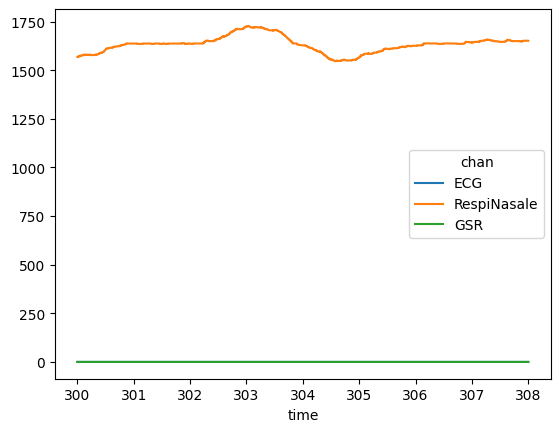

In [151]:
da.loc[['ECG','RespiNasale','GSR'],300:308].plot.line(x = 'time')

In [152]:
def norm(data):
    return (data - np.mean(data)) / np.std(data)

In [134]:
fci = gh.ecg_to_hrv(da.sel(chan = 'ECG').values, srate)

Text(0.5, 0, 'Time [s]')

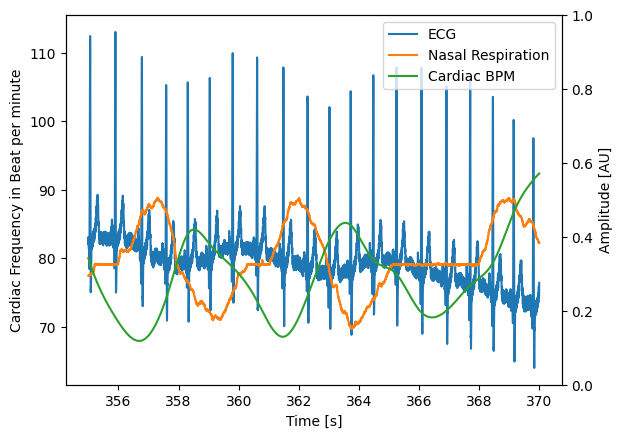

In [145]:
fig ,ax = plt.subplots()

t_start = 355
t_stop = 370
t_plot = np.arange(t_start, t_stop, 1 / srate)

sigs = {'ECG':da.sel(chan = 'ECG').values, 
        'Nasal Respiration':da.sel(chan = 'RespiNasale').values,
        'Cardiac BPM':fci}

for label, sig in sigs.items():
    data = sig[int(t_start * srate) : int(t_stop *srate)]
    
    if label != 'Cardiac BPM':
        data_plot = norm(data) * 5 + 80
    else:
        data_plot = data
        
    ax.plot(t_plot, data_plot , label = label)
    ax.legend()
ax.set_ylabel('Cardiac Frequency in Beat per minute')
ax2 = ax.twinx()
ax2.set_ylabel('Amplitude [AU]')
ax.set_xlabel('Time [s]')
# fig.savefig(save_folder + 'ECG_Respi_FCI')

In [139]:
f, Pxx = gh.spectre(fci, srate, lowest_freq= 0.1)
                    

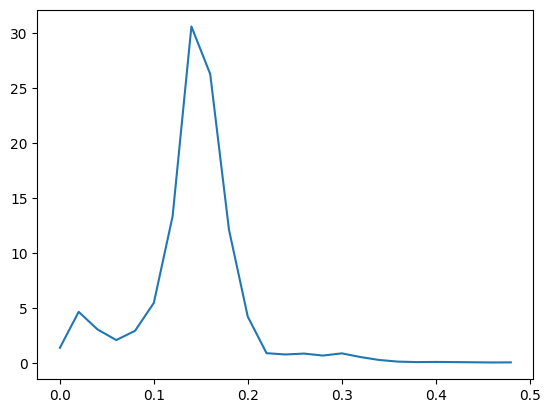

In [140]:
f_mask = f < 0.5
fig, ax = plt.subplots()
ax.plot(f[f_mask] , Pxx[f_mask])

In [ ]:
fig ,ax = plt.subplots()
t_start = 350
t_stop = 370
for i, sig in enumerate(['ECG','RespiNasale']):
    data = da.loc[sig,t_start:t_stop].values
    t = da.coords['time'].loc[t_start:t_stop].values
    if sig == 'RespiNasale':
        label_sig = 'Nasal Respiration'
    else:
        label_sig = sig
    ax.plot(t, norm(data) + i * 3 , label = label_sig)
    ax.legend()
ax.set_ylabel('Amplitude [AU]')
# fig.savefig(save_folder + 'ECG_Respi')

In [81]:
fci = gh.ecg_to_hrv(da.sel(chan = 'ECG').values, srate)

In [82]:
fci

array([55.0871289 , 55.12127943, 55.15543882, ..., 87.43482172,
       87.44487047, 87.45495199])

(-30.64495, 643.54395)

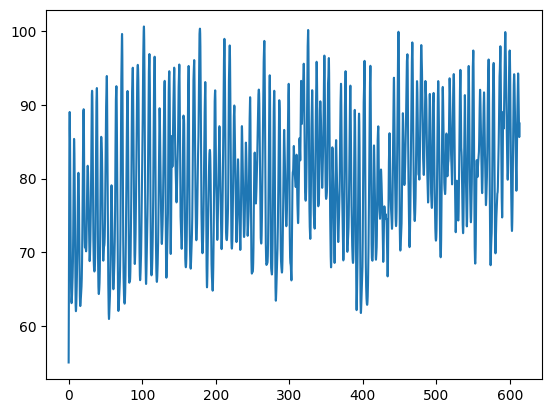

In [88]:
fig, ax = plt.subplots()
ax.plot(da.coords['time'].values, fci)
# ax.plot(da.coords['time'].values, fci)
ax.set_xlim(None, None)

In [170]:
eeg = da.loc['Oz',:].values

In [171]:
f, Pxx = gh.spectre(eeg, srate, lowest_freq = 1)

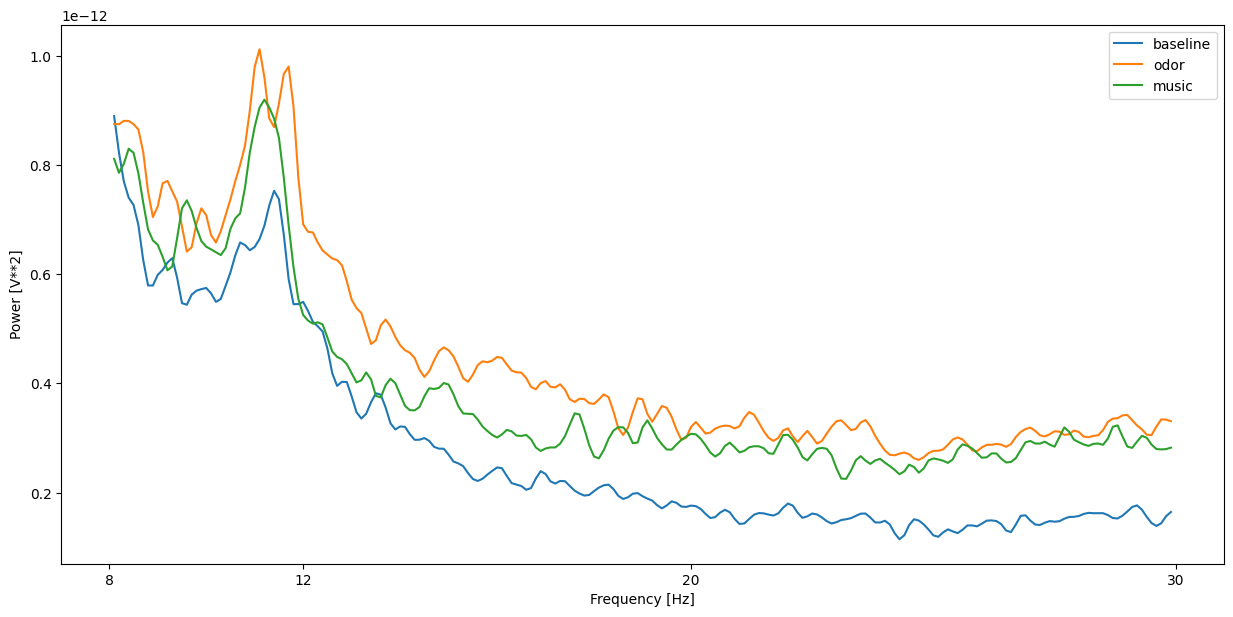

In [189]:
sessions = ['baseline','odor','music']

fig, ax = plt.subplots(figsize = (15,7))

for session in sessions:
    file = f'/crnldata/cmo/Etudiants/NBuonviso2023_Emosens3_OdeurSon_Valentin_Matthias/Data/P02/signaux/subFB02_{session}.vhdr'
    raw = mne.io.read_raw_brainvision(file, verbose = 'CRITICAL')
    da = mne_to_xarray(raw)
    eeg = da.loc['Oz',:].values
    f, Pxx = gh.spectre(eeg, srate, lowest_freq = 1, nfft_factor = 2)
    f_mask = (f > 8) & (f < 30)
    
    if session == 'odor':
        bonus = 0.8 * 1e-13
    else:
        bonus = 0
    ax.plot(f[f_mask], Pxx[f_mask] + bonus, label = session)
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Power [V**2]')
ax.legend()
ax.set_xticks([8, 12 ,20 , 30])
# ax.set_xticklabels([])
fig.savefig(save_folder + 'power_spectrum', bbox_inches= 'tight')

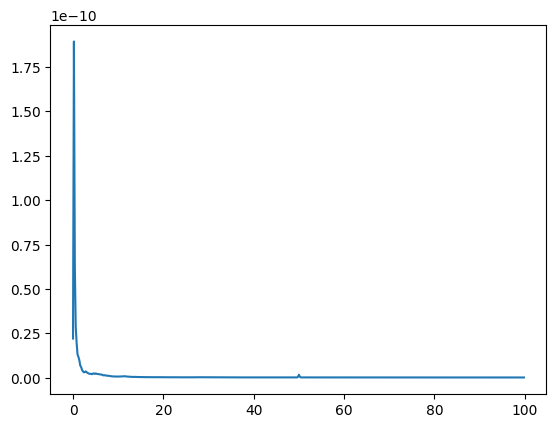

In [177]:
f_mask = f < 100
fig, ax = plt.subplots()
ax.plot(f[f_mask], Pxx[f_mask])